# E: Feature Engineering

## imports

In [1]:


import pandas as pd
import numpy as np

# for na pipeline
import warnings
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin  # for custom transformers

from joblib import dump, load

## read in data

In [2]:
df_XY = pd.read_csv("output/c_resulttradewattr.csv")

In [3]:
##  get_feature_names function
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    # check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            return []
        if trans == "passthrough":
            if hasattr(column_transformer, "_df_columns"):
                if (not isinstance(column, slice)) and all(
                    isinstance(col, str) for col in column
                ):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return [i for i in indices[column]]
        if not hasattr(trans, "get_feature_names"):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn(
                "Transformer %s (type %s) does not "
                "provide get_feature_names. "
                "Will return input column names if available"
                % (str(name), type(trans).__name__)
            )
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [
            (name, trans, None) for step, name, trans in column_transformer._iter()
        ]
    else:
        # For column transformers, follow the original method
        l_transformers = column_transformer.transformers_

    for name, trans, column in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

## custom transformers

In [4]:
class Numerizer(TransformerMixin):
    "convert numbers and % to numbers as well"
    import pandas as pd
    import numpy as np

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
#         Y = X.apply(pd.to_numeric, args=({"errors":"coerce"})).fillna(np.nan)

        Y = X.apply((lambda x: (
            pd.to_numeric(x.astype(str).str.replace(r'%', r'e-2'),errors='coerce')
            )
            )
        )

        return Y


class StringTransformer(TransformerMixin):
    import pandas as pd

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Y = pd.DataFrame(X).astype("string")
        return Y

## Add Weights

In [5]:
df_XY['Age'] = df_XY['Open_Year'] - min(df_XY['Open_Year']-1)
df_XY['Weight'] = 0.8 # hyperparam for exponential weighting
df_XY['Weight'] = df_XY['Weight'].pow(df_XY['Age'],fill_value=0)

In [6]:
df_XY['Age'].value_counts()

2    742
6    417
5    336
7    214
3    196
4    104
8     94
1     86
Name: Age, dtype: int64

In [7]:
df_XY['Weight'].value_counts()

0.640000    742
0.262144    417
0.327680    336
0.209715    214
0.512000    196
0.409600    104
0.167772     94
0.800000     86
Name: Weight, dtype: int64

## create na pipeline

In [8]:
df_XY.loc[0,df_XY.columns.duplicated()]

Series([], Name: 0, dtype: object)

In [9]:
# remove all nan columns
df_XY = df_XY.dropna(axis=1, how='all')

In [10]:
df_XY.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Open_Date', 'Close_Date',
       'Symbol', 'Quantity', 'Pnl', 'OpenAct', 'CloseAct', 'Open_Price',
       'Close_Price', 'Comm_Tot', 'DATE', 'ACTION', 'QTYCHG', 'PRICE', 'TIME',
       'UNNAMED: 6', 'COMMISSION', 'UNNAMED: 8', 'CASH CHG (PNL)', 'COMMENTS',
       'PCTRETURN', 'STARTDATE', 'COMPANY NAME (IN ALPHABETICAL ORDER)',
       'TICKER', 'STOP', '% TO STOP', 'CURRENT PRICE', '% TO TARGET',
       'AT PRICE', 'TARGET', 'EPS1', 'EPS2', 'FYEND', 'DAYSTOFYEND',
       'FYEPSNXT', 'GROWTH*0.5TO0.75', 'ROIC (BW ROA ROE)', 'TGT FWD P/E',
       'YEARS TO NORMALIZATION', 'LASTUPDATED', 'CATEGORY', 'COMMENTS.1',
       'FILENAME', 'DayOfWeek0Mon', 'Date_YahooFinance', 'Close_^GSPC',
       'Close_^VIX', 'Open_Year', 'AAII_SENT_Date', 'AAII_SENT_Bullish',
       'AAII_SENT_Neutral', 'AAII_SENT_Bearish', 'AAII_SENT_Total',
       'AAII_SENT_Bullish8WeekMovAvg', 'AAII_SENT_BullBearSpread',
       'AAII_SENT_BullishAverage', 'AAII_SENT_Bu

In [11]:
# update columns headers to clean up
df_XY.columns = list(
    pd.Series(df_XY.columns)
    .astype(str)
    .str.replace(" ", "_", regex=True)
    .str.upper()
    .str.strip()
    .str.replace("/", "_")
    .str.replace("*", "_")
)

# avoid duplicates
df_XY = df_XY.loc[:,~df_XY.columns.duplicated()]

# start with numeric, utilizng explore data before
numeric_features = df_XY.convert_dtypes().select_dtypes(include=np.number).columns.tolist()
numeric_features = numeric_features + [
    "%_TO_STOP",
    "%_TO_TARGET",
    "GROWTH_0.5TO0.75",
    "ROIC_(BW_ROA_ROE)",
    "TGT_FWD_P_E",
    "YEARS_TO_NORMALIZATION",
]
numeric_features = list(set(numeric_features))

numeric_transformer = Pipeline(
    steps=[
        ("numerizer", Numerizer()),
        ("imputer", SimpleImputer(missing_values=np.nan,strategy="median")),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="_NA_")),
        ("stringtransformer", StringTransformer()),
    ]
)

# numerical

# categorical_features = ['embarked', 'sex', 'pclass']
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features = list(set(df_XY.columns).difference(set(numeric_features)))

preprocessor_na = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    # remainder = 'passthrough' # not needed anymore
)

XY_imputed = preprocessor_na.fit_transform(df_XY)

columns = get_feature_names(preprocessor_na)

df_XY_imputed = pd.DataFrame(XY_imputed, columns=columns).convert_dtypes()

C:\Users\SW\AppData\Local\Temp\ipykernel_19956\1557959305.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pd.Series(df_XY.columns)
C:\Users\SW\AppData\Local\Temp\ipykernel_19956\3465394604.py:32: UserWarning: Transformer numerizer (type Numerizer) does not provide get_feature_names. Will return input column names if available
  warnings.warn(
C:\Users\SW\AppData\Local\Temp\ipykernel_19956\3465394604.py:32: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn(
C:\Users\SW\AppData\Local\Temp\ipykernel_19956\3465394604.py:32: UserWarning: Transformer stringtransformer (type StringTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn(


In [12]:
df_XY_imputed.head()

,CLOSE_^VIX,AAII_SENT_TOTAL,OPEN_YEAR,AAII_SENT_S&P500WEEKLYLOW,CLOSE_^GSPC,OPEN_PRICE,AAII_SENT_S&P500WEEKLYHIGH,TGT_FWD_P_E,AAII_SENT_BULLISHAVERAGE+STDEV,AAII_SENT_BULLISHAVERAGESTDEV,...,OPENACT,EPS1,AAII_SENT_DATE,COMMENTS.1,COMMENTS,SYMBOL,LASTUPDATED,CURRENT_PRICE,UNNAMED:_6,DATE
0,18.23,1.0,2015,2056.32,2063.110107,46.97212,2128.03,28.46,0.480891,0.279599,...,B,_NA_,2015-07-02,_NA_,_NA_,AER,_NA_,_NA_,USD,2015-06-16
1,18.23,1.0,2015,2056.32,2063.110107,2.435028,2128.03,28.46,0.480891,0.279599,...,B,_NA_,2015-07-02,_NA_,_NA_,FMCC,_NA_,_NA_,USD,2015-04-16
2,18.23,1.0,2015,2056.32,2063.110107,96.065,2128.03,28.46,0.480891,0.279599,...,B,_NA_,2015-07-02,_NA_,_NA_,LYB,_NA_,_NA_,_NA_,_NA_
3,18.23,1.0,2015,2056.32,2063.110107,41.795663,2128.03,28.46,0.480891,0.279599,...,B,_NA_,2015-07-02,_NA_,_NA_,AWH,_NA_,_NA_,USD,2015-05-26
4,18.23,1.0,2015,2056.32,2063.110107,3.184507,2128.03,28.46,0.480891,0.279599,...,S,_NA_,2015-07-02,_NA_,_NA_,VALE,_NA_,_NA_,USD,2015-06-30


In [13]:
df_XY_imputed.columns

Index(['CLOSE_^VIX', 'AAII_SENT_TOTAL', 'OPEN_YEAR',
       'AAII_SENT_S&P500WEEKLYLOW', 'CLOSE_^GSPC', 'OPEN_PRICE',
       'AAII_SENT_S&P500WEEKLYHIGH', 'TGT_FWD_P_E',
       'AAII_SENT_BULLISHAVERAGE+STDEV', 'AAII_SENT_BULLISHAVERAGESTDEV',
       'WEIGHT', 'AAII_SENT_NEUTRAL', 'AAII_SENT_BULLISHAVERAGE',
       'UNNAMED:_0.2', 'AAII_SENT_BULLISH8WEEKMOVAVG', 'COMMISSION',
       'AAII_SENT_BULLBEARSPREAD', 'COMM_TOT', 'AAII_SENT_BULLISH', 'QTYCHG',
       'AAII_SENT_BEARISH', 'DAYOFWEEK0MON', 'CLOSE_PRICE',
       'AAII_SENT_S&P500WEEKLYCLOSE', 'UNNAMED:_0', 'QUANTITY',
       'ROIC_(BW_ROA_ROE)', 'UNNAMED:_0.1', '%_TO_TARGET', 'AGE',
       'GROWTH_0.5TO0.75', 'YEARS_TO_NORMALIZATION', '%_TO_STOP', 'PRICE',
       'PNL', 'AT_PRICE', 'STOP', 'TIME', 'CASH_CHG_(PNL)', 'CLOSEACT',
       'UNNAMED:_8', 'ACTION', 'CLOSE_DATE', 'PCTRETURN', 'TARGET', 'EPS2',
       'OPEN_DATE', 'DAYSTOFYEND', 'CATEGORY',
       'COMPANY_NAME_(IN_ALPHABETICAL_ORDER)', 'DATE_YAHOOFINANCE', 'TICKER',
     

<AxesSubplot:>

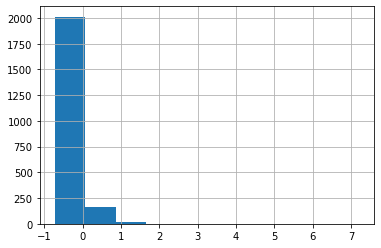

In [15]:
# df_XY_imputed["%_TO_STOP"].hist()

In [ ]:
# create target

df_XY_imputed["PCT_RET_FINAL"] = df_XY_imputed["PNL"] / (
    df_XY_imputed["OPEN_PRICE"] * df_XY_imputed["QUANTITY"]
)

In [ ]:
# TODO create moving avg

In [ ]:
# Final columns

print(df_XY_imputed.columns)

In [ ]:
## check no na's left in numerical

try:
    assert (
        df_XY_imputed[numeric_features].isna().sum().sum() == 0
    ), "NAs remain in numerical"
except:
    print("NAs remain in numerical")

## API Spec

In [ ]:
## import api spec

import yaml
from yaml import Loader

with open("data-tests/_apispecs.yaml") as f:
    api_specs = yaml.load(f, Loader=Loader)

In [ ]:
## validate based on api spec

from openapi_schema_validator import validate
import json

schema = api_specs["components"]["schemas"]["Tradelog"]

json_str = df_XY_imputed.to_json(orient="records")
json_test = json.loads(json_str)

i = 0
for row in json_test:
    try:
        validate(row, schema)
    except:
        print(f"failed on {i}th row ")
        break
    i = i + 1

print("validation completed")

In [ ]:
## save api spec to html

import os

# feed yaml file to swagger python, then create api.html
os.system(
    "python swagger_yaml_to_html.py < data-tests/_apispecs.yaml > templates/api.html"
)

## Resort & Save Results

In [ ]:
df_XY_imputed = df_XY_imputed.reindex(sorted(df_XY_imputed.columns), axis=1)

In [ ]:
## save results

df_XY_imputed.to_csv("output/e_resultcleaned.csv")

In [ ]:
## save imputer

dump(preprocessor_na, "output/e_preprocessor_na.joblib")